In [34]:
from keras.datasets import mnist
from keras.utils import np_utils

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

In [43]:
batch_size = 32
num_classes = 10
epochs = 20

In [44]:
def my_generator():
    # TODO: 音声ファイルのディレクトリからwavデータを読み込む
    # 拡張のベースとなるディレクトリの音声ファイルはすべてメモリに乗せてもよいかも
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    X_train = X_train.reshape(60000, 784)
    X_test = X_test.reshape(10000, 784)
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    X_train /= 255
    X_test /= 255
    y_train = np_utils.to_categorical(y_train, 10)

    # バッチサイズ単位でデータとラベルのタプルをyieldで返す
    while True:
        for i in range(1875):  # 1875 * 32 (batch_size) = 60000
            data_batch = X_train[i * batch_size:(i + 1) * batch_size]
            label_batch = y_train[i * batch_size:(i + 1) * batch_size]

            # TODO: ここで音声ファイルの拡張処理（ノイズ付与など） + 特徴抽出

            yield data_batch, label_batch

In [45]:
gen = my_generator()

In [46]:
gen

<generator object my_generator at 0x13b924620>

In [47]:
images, labels = gen.__next__()

In [48]:
images.shape

(32, 784)

In [49]:
labels.shape

(32, 10)

In [51]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(784,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

In [53]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

In [54]:
# steps_per_epoch: 1エポックを宣言してから次のエポックの開始前までにgeneratorから生成される
# サンプル (サンプルのバッチ) の総数． 典型的には，データにおけるユニークなサンプル数をバッチサイズで割った値です．
model.fit_generator(my_generator(), steps_per_epoch=1875, epochs=epochs, verbose=1)

Epoch 1/20
1875/1875 [==============================] - 19s - loss: 0.2161 - acc: 0.9362    
Epoch 2/20
1875/1875 [==============================] - 19s - loss: 0.1287 - acc: 0.9685    
Epoch 3/20
1875/1875 [==============================] - 18s - loss: 0.1214 - acc: 0.9732    
Epoch 4/20
1875/1875 [==============================] - 18s - loss: 0.1152 - acc: 0.9765    
Epoch 5/20
1875/1875 [==============================] - 19s - loss: 0.1113 - acc: 0.9783    
Epoch 6/20
1875/1875 [==============================] - 17s - loss: 0.1130 - acc: 0.9791    
Epoch 7/20
1875/1875 [==============================] - 16s - loss: 0.1071 - acc: 0.9814    
Epoch 8/20
1875/1875 [==============================] - 17s - loss: 0.1031 - acc: 0.9826    
Epoch 9/20
1875/1875 [==============================] - 20s - loss: 0.1074 - acc: 0.9825    
Epoch 10/20
1875/1875 [==============================] - 17s - loss: 0.1082 - acc: 0.9829    
Epoch 11/20
1875/1875 [==============================] - 19s - loss: 

## 音声用のGenerator

In [55]:
import os
import glob
import numpy as np
import librosa

In [88]:
def pad(y, length):
    arr = np.zeros(length)
    if len(y) < length:
        arr[:len(y)] = y
    else:
        arr[:] = y[:length]
    return arr

def extract_melspectrogram(wave_batch, sr, length, n_fft, hop_length, n_mels):
    melgram_batch = []
    
    for y in wave_batch:
        x = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
        melgram = librosa.power_to_db(x, ref=np.max)
        melgram_batch.append(melgram)
    
    melgram_batch = np.array(melgram_batch)

    return melgram_batch

def add_nose(wave_batch, sr, ratio=0.05):
    noise_wave_batch = []
    
    for y in wave_batch:
        # 0 - ratio
        noise = np.random.normal(0, np.std(y) * ratio, y.shape[0])

In [89]:
def sound_generator(sound_dir, batch_size=10, sr=16000, length=3,
                    n_fft=512, hop_length=256, n_mels=128):
    wave_data = []
    labels = []

    # load all data and labels from directory
    for fpath in glob.glob(os.path.join(sound_dir, '*.wav')):
        fname = os.path.basename(fpath)

        # load sound
        # メモリを圧迫する場合はwhileループの中でI/Oする方法もある
        # 8万ファイルで4GB程度なので最初にメモリに載せた方が効率よさそう
        y, sr = librosa.load(fpath, sr=sr)
        y = pad(y, sr * length)
        wave_data.append(y)

        # extract label
        label = int(fname.split('.')[0].split('_')[-1][:2]) - 1
        labels.append(label)

    wave_data = np.array(wave_data, dtype=np.float32)
    labels = np.array(labels, dtype=np.int32)

    print(wave_data.dtype, wave_data.shape)
    print(labels.dtype, labels.shape)

    while True:
        # 各バッチに対する処理
        for i in range(batch_size):  # 100 samples / 10 batch_size = 10 batch
            wave_batch = wave_data[i * batch_size:(i + 1) * batch_size]
            label_batch = labels[i * batch_size:(i + 1) * batch_size]
            
            print(i, wave_batch.shape, label_batch.shape)

            # TODO: ここで音声ファイルの拡張処理（ノイズ付与など）
            noise_wave_batch = add_noise(wave_batch, snr)

            # バッチ単位で特徴抽出
            data_batch = extract_melspectrogram(wave_batch, sr, length, n_fft, hop_length, n_mels)

            yield data_batch, label_batch

In [90]:
gen = sound_generator('../../Projects/speech-emotion-recognition/data/sounds/sample/')

In [91]:
gen.__next__()

float32 (100, 48000)
int32 (100,)
0 (10, 48000) (10,)


(array([[[-32.30982954, -34.984229  , -27.52332604, ..., -80.        ,
          -80.        , -80.        ],
         [-28.24036922, -33.31718039, -27.09672633, ..., -80.        ,
          -80.        , -80.        ],
         [-26.06931372, -32.02468645, -26.63682338, ..., -80.        ,
          -80.        , -80.        ],
         ..., 
         [-80.        , -80.        , -80.        , ..., -80.        ,
          -80.        , -80.        ],
         [-80.        , -80.        , -80.        , ..., -80.        ,
          -80.        , -80.        ],
         [-80.        , -80.        , -80.        , ..., -80.        ,
          -80.        , -80.        ]],
 
        [[-57.16541029, -75.87655468, -75.61125944, ..., -80.        ,
          -80.        , -80.        ],
         [-57.04721801, -76.0775156 , -62.90697491, ..., -80.        ,
          -80.        , -80.        ],
         [-56.86804705, -76.23355357, -59.8938694 , ..., -80.        ,
          -80.        , -80.   

## S/N比

In [11]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
y1, sr = librosa.load('data/hand.wav', sr=16000)

In [4]:
y2, sr = librosa.load('data/ear.wav', sr=16000)

In [5]:
y1[:10]

array([ 0.00244141,  0.00311279,  0.00396729,  0.00375366,  0.003479  ,
        0.00445557,  0.00491333,  0.00393677,  0.00360107,  0.00357056], dtype=float32)

In [6]:
y1.shape

(16518,)

In [7]:
y2.shape

(18276,)

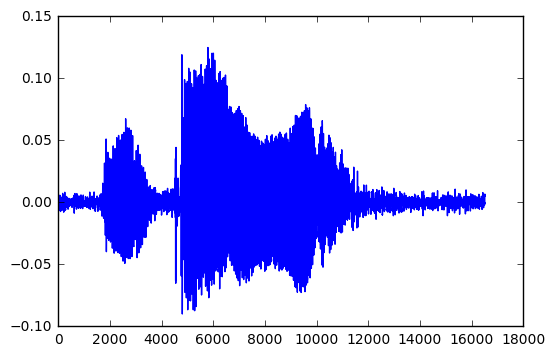

In [8]:
plt.plot(y1)

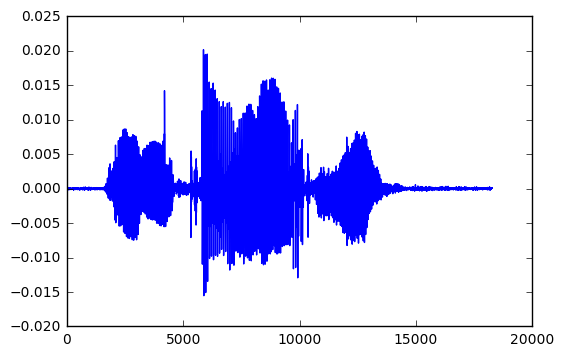

In [9]:
plt.plot(y2)

In [12]:
print(np.mean(y2))
print(np.std(y2))

1.51953e-07
0.0032909


In [22]:
import numpy as np
noise = np.random.normal(0, np.std(y2) * 0.08, y2.shape[0])

In [23]:
noise.shape

(18276,)

In [24]:
noise

array([  1.76203666e-04,   9.41245502e-05,   1.41392443e-04, ...,
         3.87761069e-04,   3.28565603e-05,  -2.13289317e-04])

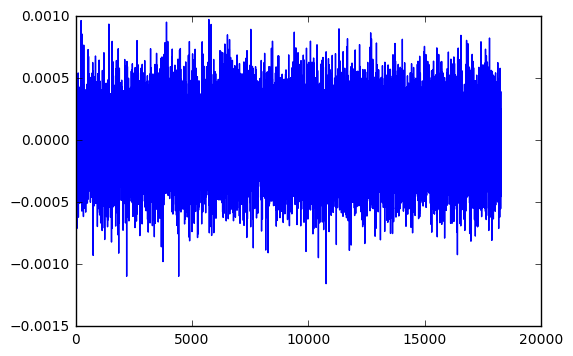

In [25]:
plt.plot(noise)

In [26]:
librosa.output.write_wav('noise.wav', noise, sr=16000)

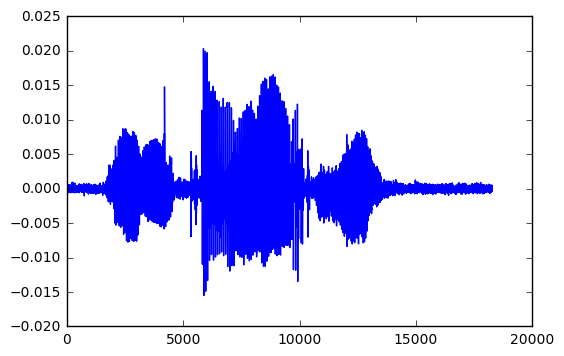

In [27]:
plt.plot(y2 + noise)

In [28]:
librosa.output.write_wav('noise_sound.wav', y2 + noise, sr=16000)

In [29]:
y2

array([ -1.83105469e-04,  -1.52587891e-04,  -9.15527344e-05, ...,
         6.10351562e-05,   6.10351562e-05,   6.10351562e-05], dtype=float32)

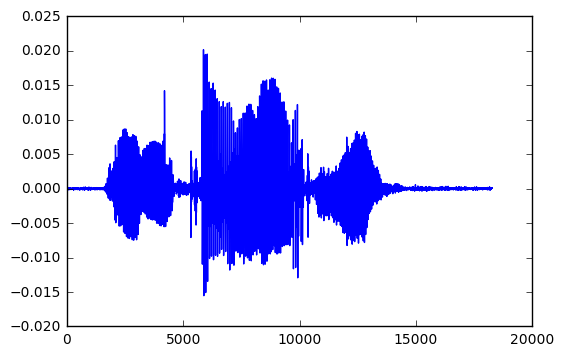

In [30]:
plt.plot(y2)